In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('output.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_rate         3585 non-null   int64  
 1   host_identity_verified     3585 non-null   int64  
 2   host_total_listings_count  3585 non-null   int64  
 3   city                       3585 non-null   int64  
 4   is_location_exact          3585 non-null   int64  
 5   property_type              3585 non-null   int64  
 6   room_type                  3585 non-null   int64  
 7   accommodates               3585 non-null   int64  
 8   bathrooms                  3585 non-null   float64
 9   bedrooms                   3585 non-null   float64
 10  beds                       3585 non-null   float64
 11  bed_type                   3585 non-null   int64  
 12  amenities                  3585 non-null   int64  
 13  price                      3585 non-null   int64

In [3]:
# Remove duplicates
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_rate         3585 non-null   int64  
 1   host_identity_verified     3585 non-null   int64  
 2   host_total_listings_count  3585 non-null   int64  
 3   city                       3585 non-null   int64  
 4   is_location_exact          3585 non-null   int64  
 5   property_type              3585 non-null   int64  
 6   room_type                  3585 non-null   int64  
 7   accommodates               3585 non-null   int64  
 8   bathrooms                  3585 non-null   float64
 9   bedrooms                   3585 non-null   float64
 10  beds                       3585 non-null   float64
 11  bed_type                   3585 non-null   int64  
 12  amenities                  3585 non-null   int64  
 13  price                      3585 non-null   int64

In [4]:
df.columns[1]

'host_identity_verified'

C:\Users\13343\AppData\Local\Temp\ipykernel_11236\2013105819.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\13343\AppData\Local\Temp\ipykernel_11236\2013105819.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\13343\AppData\Local\Temp\ipykernel_11236\2013105819.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\13343\AppData\Local\Temp\ipykernel_11236\2013105819.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\13343\AppData\Local\Temp\ipykernel_11236\2013105819.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Us

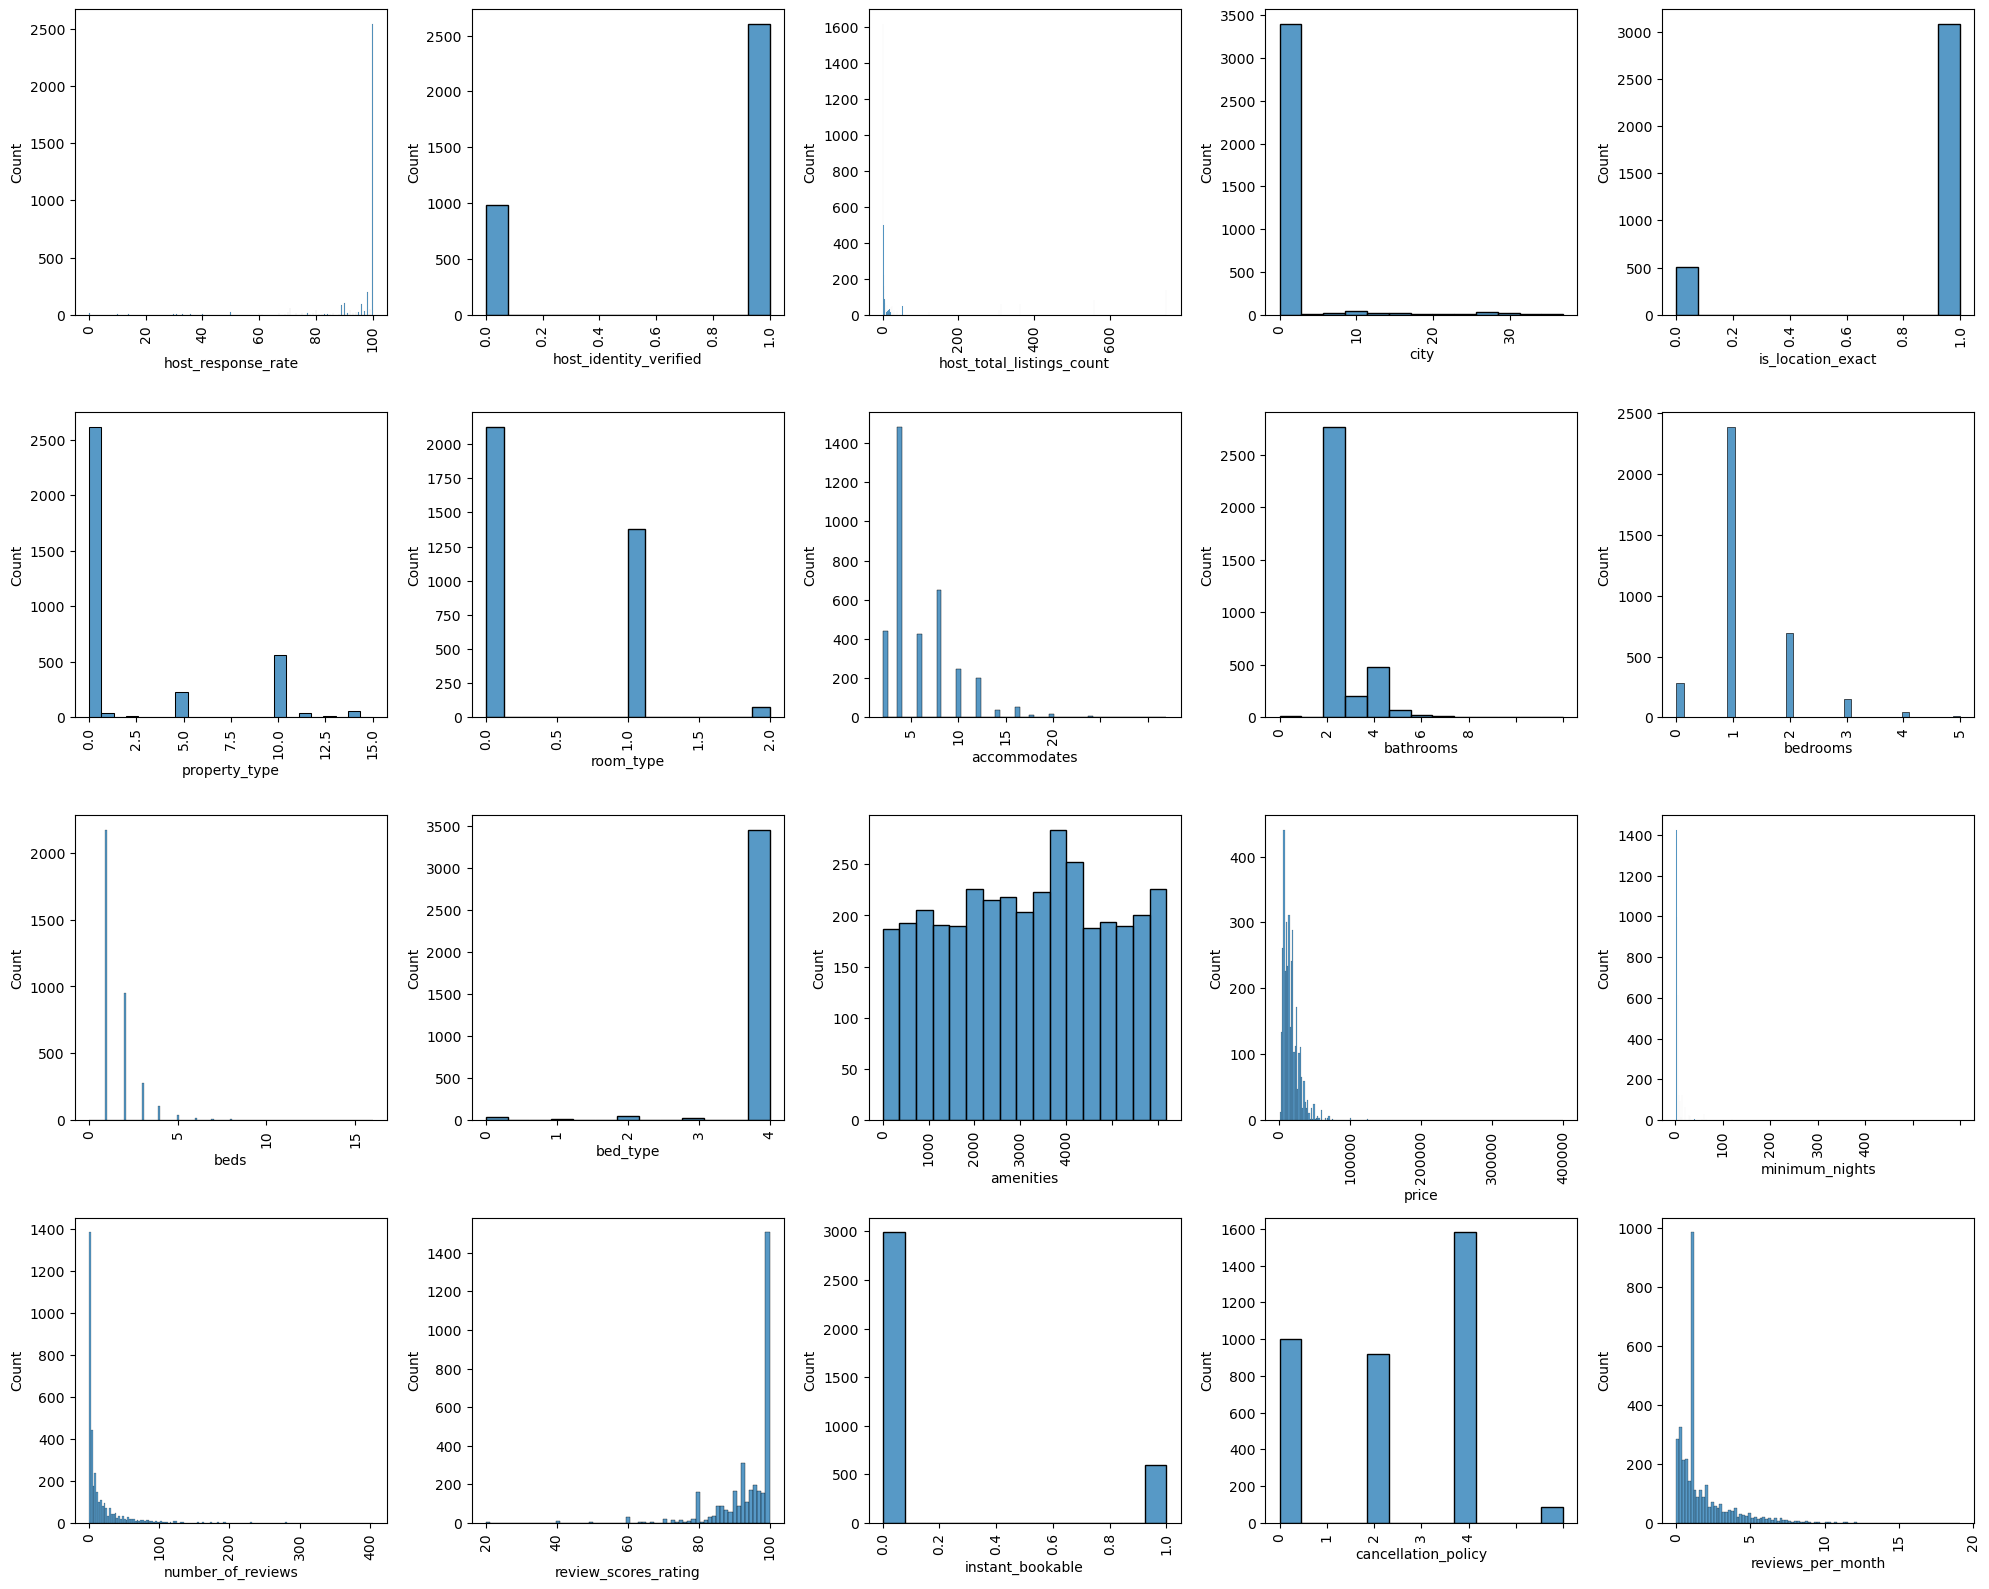

In [5]:
data = df.iloc[:, :-1]

num_cols = data.shape[1]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))

axes = axes.flatten()

# Iterating over each column
for i, col in enumerate(data.columns):
    ax = axes[i]
    sns.histplot(x=data[col], ax=ax)
    ax.set_xlabel(col)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    


# Adjusting the spacing between subplots
plt.tight_layout()

# Displaying the plot
plt.show()

1. host_reponse_rate: The outliers are close to zero, but it is meaningful because a low reponse rate will impact the price negatively.
2. host_identity_verified: no outlier
3. host_total_listings_count: there are extremely high counts, which may result from real estate companies, needs to be removed
4. city: it is encoded with number, needs to be hot_coded ?
5. is_location_exact: no outlier
6. property_type: one hot code
7. room type: one hot code
8. accommodates: check the correlation with other features and decide later
9. bathrooms, bedrooms, beds and bed_type are corellated, keep them.
10. amentities: keep
11. price: highly skewed, remove the highest outliers.
12. minimun nights: cannot remove outlier, because high value may indicate fraud
13. number_of_reviews: keep, because this number reflects many facts of the pricing and it should be kept
14. review_scores_rating: the rating is highly correlated to the fraud situation.
15. instant_bookable: keep
16. cancellation_polity: one hot code
17. reviews_per_month: keep this parameter since it is highly related to the fraud (see the heatmap)

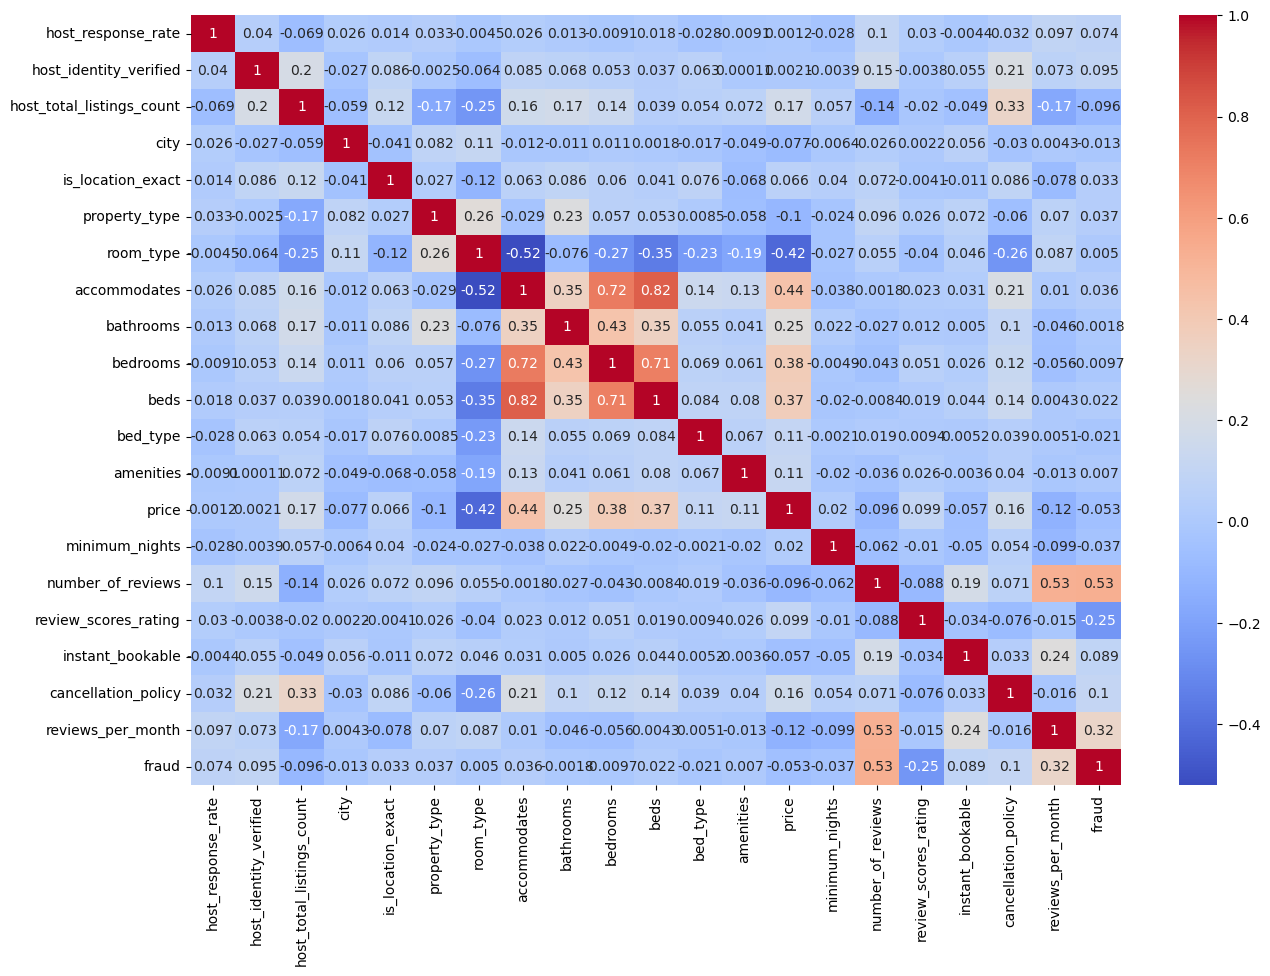

In [6]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Accommodates has a high correlation with beds and bedrooms, but has a higher correlatoin with fraud than the beds, so keep this.

review scores rating: high correlation with fraud, keep.

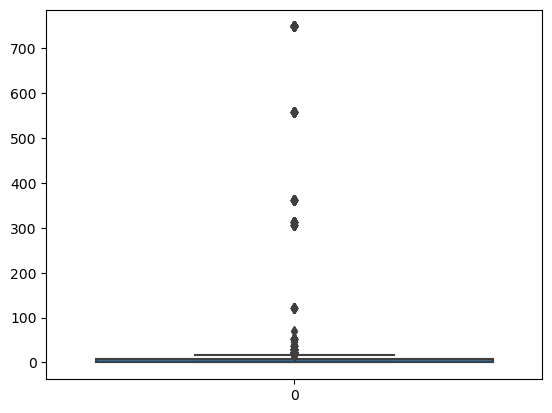

In [7]:
sns.boxplot(df['host_total_listings_count'])
df_noout = df[df['host_total_listings_count'] < 100]

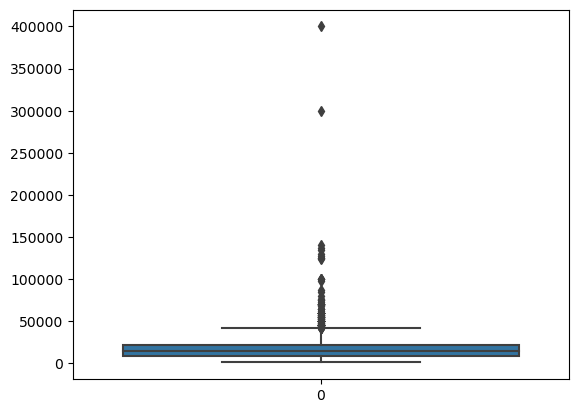

In [8]:
sns.boxplot(df['price'])
df_noout = df_noout[df_noout['price'] < 160000]

<Axes: >

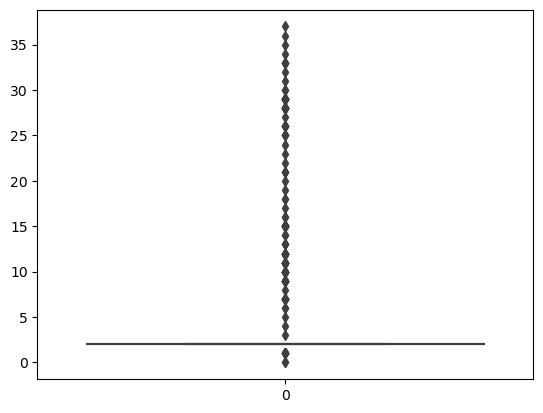

In [9]:
sns.boxplot(df_noout['city'])

In [10]:
one_hot_encoded = pd.get_dummies(df_noout['city'], prefix='city')

# Concatenate the one-hot encoded dataframe with the original dataframe
df_noout = pd.concat([df_noout, one_hot_encoded], axis=1)

# Drop the original 'city' column
# df_noout = df_noout.drop('city', axis=1)

In [11]:
df_noout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3584
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_rate         3211 non-null   int64  
 1   host_identity_verified     3211 non-null   int64  
 2   host_total_listings_count  3211 non-null   int64  
 3   city                       3211 non-null   int64  
 4   is_location_exact          3211 non-null   int64  
 5   property_type              3211 non-null   int64  
 6   room_type                  3211 non-null   int64  
 7   accommodates               3211 non-null   int64  
 8   bathrooms                  3211 non-null   float64
 9   bedrooms                   3211 non-null   float64
 10  beds                       3211 non-null   float64
 11  bed_type                   3211 non-null   int64  
 12  amenities                  3211 non-null   int64  
 13  price                      3211 non-null   int64

The price's distribution over 100000 is extremely low, so deem them as outliers

<Axes: >

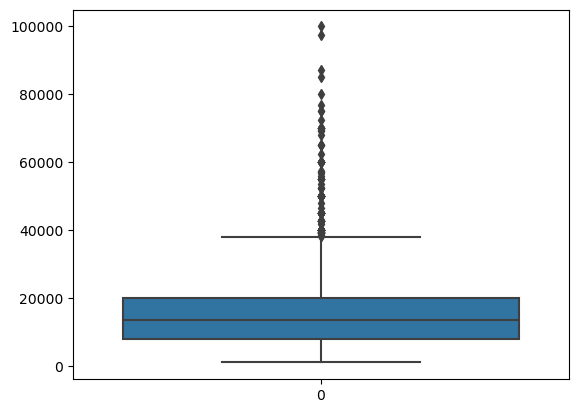

In [12]:
df_noout = df_noout[df_noout['price'] < 100000]
sns.boxplot(df_noout['price'])

## Modelling with logistic regression model

### Naive Bayes Classifier

In [13]:
df_noout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3584
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_rate         3201 non-null   int64  
 1   host_identity_verified     3201 non-null   int64  
 2   host_total_listings_count  3201 non-null   int64  
 3   city                       3201 non-null   int64  
 4   is_location_exact          3201 non-null   int64  
 5   property_type              3201 non-null   int64  
 6   room_type                  3201 non-null   int64  
 7   accommodates               3201 non-null   int64  
 8   bathrooms                  3201 non-null   float64
 9   bedrooms                   3201 non-null   float64
 10  beds                       3201 non-null   float64
 11  bed_type                   3201 non-null   int64  
 12  amenities                  3201 non-null   int64  
 13  price                      3201 non-null   int64

host_identity_verified   
host_total_listings_count
is_location_exact        
property_type            
room_type                
accommodates             
bathrooms                
bedrooms                 
beds                     
bed_type                 
amenities                
price                    
minimum_nights           
number_of_reviews        
review_scores_rating     
instant_bookable         
cancellation_policy      
reviews_per_month        
fraud    
city

In [14]:
df_noout['accommodates']

0       1
1       2
2       4
3       2
4       3
       ..
3580    1
3581    1
3582    2
3583    1
3584    4
Name: accommodates, Length: 3201, dtype: int64

In [75]:
cat_columns = ['property_type',
               'room_type',
               'bed_type',
               'accommodates',
               'instant_bookable',
               'cancellation_policy',
               'city']
num_columns = ['host_identity_verified',
               'host_total_listings_count',
               'is_location_exact',
               'bathrooms',
               'bedrooms',
               'beds',
               'amenities',
               'price',
               'minimum_nights',
               'number_of_reviews',
               'review_scores_rating',
               'reviews_per_month']
target = 'fraud'

In [82]:
print(df_noout.cancellation_policy)

0       2
1       2
2       2
3       1
4       1
       ..
3580    1
3581    0
3582    2
3583    2
3584    2
Name: cancellation_policy, Length: 3201, dtype: int64


In [117]:
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
num_transformer = StandardScaler()
preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, cat_columns),
                                                 ('num', num_transformer, num_columns)])

In [118]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_noout[cat_columns + num_columns], df_noout[target], test_size=0.2, random_state=42)


In [119]:
# x_train_transformed = preprocessor.fit_transform(X_train)
# x_test_transformed = preprocessor.fit_transform(X_test)

preprocessor.fit(df_noout[cat_columns + num_columns])
x_train_transformed = preprocessor.transform(X_train)
x_test_transformed = preprocessor.transform(X_test)

c:\Users\13343\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [120]:
print(X_train.shape, X_test.shape)

(2560, 19) (641, 19)


In [121]:
print(x_train_transformed.shape, x_test_transformed.shape)

(2560, 91) (641, 91)


In [123]:
encoded_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_columns))
all_feat = num_columns + encoded_columns

X_train_transformed = pd.DataFrame(x_train_transformed, columns=all_feat)
X_test_transformed = pd.DataFrame(x_test_transformed, columns=all_feat)

In [127]:
# Hyperparameter tuning
# select parameters
params_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
params_knn = {'n_neighbors': list(range(1,100)), 'weights': ['uniform', 'distance']}

# Define the models
nb = GaussianNB()
knn = KNeighborsClassifier()

# Define GridSearchCV
gridsearch_nb = GridSearchCV(nb, params_nb, cv=5, scoring='roc_auc')
    #nb, params_nb, cv=5)
randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=10, scoring='roc_auc')

# Fit models
gridsearch_nb.fit(X_train_transformed, y_train)
randomsearch_knn.fit(X_train_transformed, y_train)

# Get the best parameters
print("Best parameters for Naive Bayes: ", gridsearch_nb.best_params_)
print("Best parameters for KNN: ", randomsearch_knn.best_params_)

Best parameters for Naive Bayes:  {'var_smoothing': 1.0}
Best parameters for KNN:  {'weights': 'distance', 'n_neighbors': 70}


In [130]:
# Apply the best parameters
nb_best = GaussianNB(**gridsearch_nb.best_params_)
knn_best = KNeighborsClassifier(**randomsearch_knn.best_params_)

# Perform cross-validation
cv_scores_nb = cross_val_score(nb_best, X_train_transformed, y_train, cv=5, scoring='roc_auc')
cv_scores_knn = cross_val_score(knn_best, X_train_transformed, y_train, cv=5, scoring='roc_auc')

print("Cross-validation scores for Naive Bayes: ", cv_scores_nb)
print("Cross-validation scores for KNN: ", cv_scores_knn)

# Fit the models with the best parameters
nb_best.fit(X_train_transformed, y_train)
knn_best.fit(X_train_transformed, y_train)

# Evaluate on the test set
y_pred_nb = nb_best.predict(X_test_transformed)
y_pred_knn = knn_best.predict(X_test_transformed)

print("Test accuracy for Naive Bayes: ", accuracy_score(y_test, y_pred_nb))
print("Test accuracy for KNN: ", accuracy_score(y_test, y_pred_knn))

Cross-validation scores for Naive Bayes:  [0.86692233 0.83778542 0.85162655 0.84307502 0.83205501]
Cross-validation scores for KNN:  [0.86544565 0.87415146 0.88250463 0.85147227 0.84829851]
Test accuracy for Naive Bayes:  0.8081123244929798
Test accuracy for KNN:  0.8065522620904836


In [131]:
# Compute metrics
print("Naive Bayes Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_nb))
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))
print("Precision: ", precision_score(y_test, y_pred_nb))
print("Recall: ", recall_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test, y_pred_nb))

print("\nK-Nearest Neighbors Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_knn))
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Precision: ", precision_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))
print("F1 Score: ", f1_score(y_test, y_pred_knn))

Naive Bayes Metrics: 
Confusion Matrix:  [[467  16]
 [107  51]]
Accuracy:  0.8081123244929798
Precision:  0.7611940298507462
Recall:  0.3227848101265823
F1 Score:  0.45333333333333337

K-Nearest Neighbors Metrics: 
Confusion Matrix:  [[472  11]
 [113  45]]
Accuracy:  0.8065522620904836
Precision:  0.8035714285714286
Recall:  0.2848101265822785
F1 Score:  0.42056074766355145
